In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
import rpy2.robjects 
from rpy2.robjects.packages import importr
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

import pandas.rpy.common as com
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import ShuffleSplit


r = rpy2.robjects.r


In [2]:
features=pd.read_csv('train_features_2013-03-07.csv')
salaries=pd.read_csv('train_salaries_2013-03-07.csv')

In [3]:
###run summary stats
##identify different datatypes
strings=[t for t in features.columns if features[t].dtype=='object']

##summaries on strings
features[strings].describe()      

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685306512,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [4]:
##numerical features
features.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [5]:
###closer examination of jobType and degree to see if they are ordinal or categorical
print(features.jobType.unique())
print(features.degree.unique())

['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']


In [6]:
###recode degree as ordinal and JobType may have to be done
##maycome back and recode to dummy variables
features['degree'] = features['degree'].astype('category')
features['degree'] = features['degree'].cat.reorder_categories(['NONE','HIGH_SCHOOL','BACHELORS','MASTERS', 'DOCTORAL'], ordered=True)
features['degree1'] = features['degree'].cat.codes

In [7]:
###transform other variables into dummies
for t in ['jobType','major','industry']:
    new=pd.get_dummies(features[t],prefix=t)
    features=pd.concat([features, new], axis=1)

In [8]:
features.describe()

,yearsExperience,milesFromMetropolis,degree1,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,1.815355,0.124778,0.124369,0.125046,0.124971,0.124594,0.125121,0.125886,...,0.057801,0.532355,0.058410,0.142943,0.142819,0.142867,0.142755,0.142771,0.142639,0.143206
std,7.212391,28.877733,1.423751,0.330467,0.330002,0.330771,0.330686,0.330258,0.330856,0.331721,...,0.233367,0.498952,0.234517,0.350015,0.349888,0.349937,0.349823,0.349839,0.349705,0.350283
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,75.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,99.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
###run correlation matrix
features.corr()

,yearsExperience,milesFromMetropolis,degree1,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
yearsExperience,1.000000,0.000673,0.000219,0.000308,-0.000102,0.000966,-0.001191,-0.000005,-0.000265,0.000223,...,-0.000005,0.000108,-0.000268,-0.001003,0.000437,0.000981,-0.001105,0.000798,0.000129,-0.000236
milesFromMetropolis,0.000673,1.000000,0.001781,-0.000664,0.000567,0.000676,-0.001118,0.001708,-0.000409,0.000569,...,-0.000917,-0.001623,0.000222,0.000343,0.000808,0.000048,-0.000398,-0.000551,0.000687,-0.000936
degree1,0.000219,0.001781,1.000000,0.050379,0.049125,0.050037,-0.349267,0.049431,0.049056,0.051130,...,0.206373,-0.779356,0.207566,0.000912,-0.000484,0.000298,0.001022,0.000594,-0.002295,-0.000050
jobType_CEO,0.000308,-0.000664,0.050379,1.000000,-0.142300,-0.142742,-0.142693,-0.142447,-0.142791,-0.143290,...,0.011796,-0.050957,0.014719,0.000621,0.000150,0.000747,-0.001615,0.000591,-0.000824,0.000329
jobType_CFO,-0.000102,0.000567,0.049125,-0.142300,1.000000,-0.142475,-0.142426,-0.142180,-0.142524,-0.143021,...,0.014041,-0.050205,0.013498,-0.001417,-0.000929,0.000777,0.001920,-0.000635,-0.000770,0.001052
jobType_CTO,0.000966,0.000676,0.050037,-0.142742,-0.142475,1.000000,-0.142868,-0.142622,-0.142966,-0.143465,...,0.014512,-0.050945,0.013176,-0.000729,0.000450,-0.000794,-0.001581,0.001936,0.000921,-0.000201
jobType_JANITOR,-0.001191,-0.001118,-0.349267,-0.142693,-0.142426,-0.142868,1.000000,-0.142573,-0.142917,-0.143416,...,-0.093603,0.354202,-0.094125,0.001886,0.000197,-0.000477,-0.001100,-0.001273,0.000236,0.000530
jobType_JUNIOR,-0.000005,0.001708,0.049431,-0.142447,-0.142180,-0.142622,-0.142573,1.000000,-0.142671,-0.143169,...,0.013200,-0.049764,0.012323,0.000027,0.001563,-0.000358,0.001451,-0.002531,-0.000112,-0.000040
jobType_MANAGER,-0.000265,-0.000409,0.049056,-0.142791,-0.142524,-0.142966,-0.142917,-0.142671,1.000000,-0.143515,...,0.013313,-0.050404,0.014456,0.001890,-0.000861,0.000720,-0.001112,0.000150,0.000120,-0.000907
jobType_SENIOR,0.000223,0.000569,0.051130,-0.143290,-0.143021,-0.143465,-0.143416,-0.143169,-0.143515,1.000000,...,0.011686,-0.052190,0.013729,-0.001520,0.000828,-0.000715,-0.000223,0.001871,0.000498,-0.000737


In [10]:
###highlight high correlation between independent variables since the matrix is so big
highs=[]

corr_ma=features.corr()

for x in corr_ma.columns:
    u=x.split('_')[0]
    for y in corr_ma.index:
        p=y.split('_')[0]
        if (x != y) & (u != p) &  (abs(corr_ma.loc[x,y]) > .6):
            print( x + ' ---' + y + 'have a correlation of'+ str(corr_ma.loc[x,y]))



degree1 ---major_NONEhave a correlation of-0.779355869506
major_NONE ---degree1have a correlation of-0.779355869506


In [11]:
###Check for multicollinearity between the two variables
independent=[u'yearsExperience', u'milesFromMetropolis', u'jobType_CEO',
       u'jobType_CFO', u'jobType_CTO', u'jobType_JUNIOR','degree1',
       u'jobType_MANAGER', u'jobType_SENIOR', u'jobType_VICE_PRESIDENT',
       u'industry_AUTO',
       u'industry_EDUCATION', u'industry_FINANCE', u'industry_HEALTH',
       u'industry_OIL',  u'industry_WEB']
sm.OLS(features.major_NONE,features[independent] ).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             major_NONE   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                 1.452e+05
Date:                Thu, 27 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:36:23   Log-Likelihood:            -5.0328e+05
No. Observations:             1000000   AIC:                         1.007e+06
Df Residuals:                  999984   BIC:                         1.007e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
yearsExperience            0.0131   5.15e-05    254.937      0.000         0.013     0.013
milesFromMetropolis        0.0034   1.28e-05    263.748      0.000         0.003     0.003
jobType_CEO                0.2905      0.002    191.267      0.000         0.288     0.293
jobType_CFO                0.2901      0.002    190.865      0.000         0.287     0.293
jobType_CTO                0.2904      0.002    191.318      0.000         0.287     0.293
jobType_JUNIOR             0.2909      0.002    191.478      0.000         0.288     0.294
degree1                   -0.2460      0.000   -822.869      0.000        -0.247    -0.245
jobType_MANAGER            0.2905      0.002    191.496      0.000         0.287     0.293
jobType_SENIOR             0.2899      0.002    191.312      0.000         0.287     0.293
jobType_VICE_PRESIDENT     0.2924      0.002    192.799      0.000         0.289     0.295
industry_AUTO              0.3995      0.001    294.079      0.000         0.397     0.402
industry_EDUCATION         0.4008      0.001    294.823      0.000         0.398     0.403
industry_FINANCE           0.3991      0.001    293.573      0.000         0.396     0.402
industry_HEALTH            0.3999      0.001    294.132      0.000         0.397     0.403
industry_OIL               0.4011      0.001    294.960      0.000         0.398     0.404
industry_WEB               0.4006      0.001    295.046      0.000         0.398     0.403
==============================================================================
Omnibus:                    15704.309   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16457.882
Skew:                           0.314   Prob(JB):                         0.00
Kurtosis:                       2.995   Cond. No.                         463.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
###check for multicollinearity (VIF over 5)
1/(1-sm.OLS(features.major_NONE,features[independent] ).fit().rsquared)

3.322997228260816

In [13]:
###check all other variables
##all variables to run
all=features.columns[6:]

##independents with one in each group dropped
indie=[u'yearsExperience', u'milesFromMetropolis', u'degree1',u'jobType_CEO', u'jobType_CFO',
       u'jobType_CTO',  u'jobType_JUNIOR', 
       u'jobType_MANAGER', u'jobType_SENIOR', u'jobType_VICE_PRESIDENT',
       u'major_BIOLOGY', u'major_BUSINESS', u'major_CHEMISTRY',
       u'major_COMPSCI', u'major_ENGINEERING', u'major_LITERATURE',
       u'major_MATH',  u'major_PHYSICS', u'industry_AUTO',
       u'industry_SERVICE', u'industry_FINANCE', u'industry_HEALTH',
       u'industry_OIL',  u'industry_WEB']

### loop through them all finding the ones that a VIF over 5
for l in all:
    independent1=[q for q in indie if q.split('_')[0]!=l.split('_')[0]]
    rs=sm.OLS( features[l] , features[independent1] ).fit().rsquared
    vif=1/(1-rs)
    if vif>5:
        print(l + 'is greater than 5 at '+str(vif))


### no multicollinearity found

In [14]:
##copy data set
feature1=features[indie + [u'jobId', u'companyId', u'industry', u'degree','jobType']].copy()

###standardize only numeric variables by dividing 2* sd 
###(reference:http://www.stat.columbia.edu/~gelman/research/published/ape17.pdf)
for x in [u'yearsExperience', u'milesFromMetropolis', u'degree1']:
    std=feature1[x].std()
    feature1[x]=(feature1[x])/(2*std)

In [15]:
feature2=pd.merge(feature1, salaries, on='jobId')

In [16]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
feature2["companyId1"] = lb_make.fit_transform(feature2["companyId"])

In [17]:
feature2.groupby('companyId').mean()['salary'][:20]

companyId
COMP0     115.963615
COMP1     116.048609
COMP10    116.019800
COMP11    116.113029
COMP12    116.086485
COMP13    116.561795
COMP14    116.303495
COMP15    115.847117
COMP16    116.358424
COMP17    116.315940
COMP18    115.597167
COMP19    115.756548
COMP2     116.759223
COMP20    115.934192
COMP21    116.539156
COMP22    116.207644
COMP23    116.261277
COMP24    116.176489
COMP25    116.232174
COMP26    115.959683
Name: salary, dtype: float64

not much variability between companies

In [18]:
feature2.groupby(['industry', 'degree']).mean()[['salary']]

salary
industry  degree                 
AUTO      BACHELORS    118.234848
          DOCTORAL     128.069359
          HIGH_SCHOOL   95.805843
          MASTERS      123.239183
          NONE          92.340695
EDUCATION BACHELORS    107.975063
          DOCTORAL     118.323663
          HIGH_SCHOOL   86.298461
          MASTERS      113.140163
          NONE          82.281235
FINANCE   BACHELORS    140.375583
          DOCTORAL     150.635400
          HIGH_SCHOOL  116.183275
          MASTERS      145.283442
          NONE         112.638157
HEALTH    BACHELORS    125.444964
          DOCTORAL     135.117068
          HIGH_SCHOOL  101.549296
          MASTERS      130.545277
          NONE          97.286797
OIL       BACHELORS    140.997392
          DOCTORAL     150.744987
          HIGH_SCHOOL  116.307842
          MASTERS      145.605445
          NONE         112.646407
SERVICE   BACHELORS    113.233762
          DOCTORAL     123.018179
          HIGH_SCHOOL   91.241363
          MASTERS      118.299083
          NONE          87.404719
WEB       BACHELORS    132.100092
          DOCTORAL     142.313758
          HIGH_SCHOOL  105.994693
          MASTERS      137.235639
          NONE         102.748705

a lot of variability between industries making it a good candidate for mixed effects 

## OLS Regression

In [19]:
#test train split
train=feature2.sample(frac=0.80,random_state=200)
test=feature2.drop(train.index)

first=sm.OLS(train.salary, train[indie]).fit()

first.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 9.697e+05
Date:                Thu, 27 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:37:42   Log-Likelihood:            -3.6191e+06
No. Observations:              800000   AIC:                         7.238e+06
Df Residuals:                  799976   BIC:                         7.238e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
yearsExperience           36.8850      0.046    796.351      0.000        36.794    36.976
milesFromMetropolis      -14.9266      0.046   -323.904      0.000       -15.017   -14.836
degree1                   17.9855      0.080    225.930      0.000        17.829    18.142
jobType_CEO               80.9161      0.095    852.876      0.000        80.730    81.102
jobType_CFO               71.0734      0.095    748.192      0.000        70.887    71.260
jobType_CTO               71.1340      0.095    750.002      0.000        70.948    71.320
jobType_JUNIOR            31.0669      0.095    327.473      0.000        30.881    31.253
jobType_MANAGER           51.0420      0.095    538.308      0.000        50.856    51.228
jobType_SENIOR            41.1091      0.095    433.922      0.000        40.923    41.295
jobType_VICE_PRESIDENT    60.8960      0.095    641.909      0.000        60.710    61.082
major_BIOLOGY              2.1993      0.126     17.521      0.000         1.953     2.445
major_BUSINESS             9.8919      0.125     78.886      0.000         9.646    10.138
major_CHEMISTRY            3.3002      0.125     26.399      0.000         3.055     3.545
major_COMPSCI              6.1885      0.125     49.328      0.000         5.943     6.434
major_ENGINEERING         12.8696      0.125    102.733      0.000        12.624    13.115
major_LITERATURE          -1.5038      0.125    -11.990      0.000        -1.750    -1.258
major_MATH                 7.2881      0.126     57.844      0.000         7.041     7.535
major_PHYSICS              4.3894      0.126     34.955      0.000         4.143     4.636
industry_AUTO             26.7373      0.085    315.626      0.000        26.571    26.903
industry_SERVICE          21.7184      0.085    256.101      0.000        21.552    21.885
industry_FINANCE          47.8721      0.085    565.002      0.000        47.706    48.038
industry_HEALTH           32.9480      0.085    388.675      0.000        32.782    33.114
industry_OIL              47.9741      0.085    565.774      0.000        47.808    48.140
industry_WEB              38.8794      0.085    459.081      0.000        38.713    39.045
==============================================================================
Omnibus:                     6844.290   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4617.356
Skew:                          -0.045   Prob(JB):                         0.00
Kurtosis:                       2.639   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

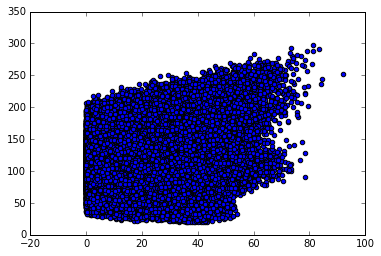

In [20]:
plt.scatter(abs(test.salary-first.predict(test[indie])),test.salary)

shows heteroskedasticity so including robustness

In [21]:
##run robust model
second=sm.RLM(train.salary, train[indie], M=sm.robust.norms.HuberT()).fit()

second.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 salary   No. Observations:               800000
Model:                            RLM   Df Residuals:                   799976
Method:                          IRLS   Df Model:                           23
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 27 Apr 2017                                         
Time:                        22:38:50                                         
No. Iterations:                    16                                         
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
yearsExperience           36.6343      0.049    754.323      0.000        36.539    36.729
milesFromMetropolis      -14.2458      0.048   -294.820      0.000       -14.341   -14.151
degree1                   18.1688      0.083    217.666      0.000        18.005    18.332
jobType_CEO               79.9534      0.099    803.715      0.000        79.758    80.148
jobType_CFO               70.1847      0.100    704.632      0.000        69.989    70.380
jobType_CTO               70.2588      0.099    706.481      0.000        70.064    70.454
jobType_JUNIOR            30.3370      0.099    304.975      0.000        30.142    30.532
jobType_MANAGER           50.2674      0.099    505.596      0.000        50.073    50.462
jobType_SENIOR            40.3741      0.099    406.436      0.000        40.179    40.569
jobType_VICE_PRESIDENT    60.0886      0.099    604.075      0.000        59.894    60.284
major_BIOLOGY              2.0150      0.132     15.310      0.000         1.757     2.273
major_BUSINESS             9.5100      0.131     72.329      0.000         9.252     9.768
major_CHEMISTRY            3.0908      0.131     23.579      0.000         2.834     3.348
major_COMPSCI              6.0172      0.132     45.742      0.000         5.759     6.275
major_ENGINEERING         12.4283      0.131     94.617      0.000        12.171    12.686
major_LITERATURE          -1.9637      0.132    -14.932      0.000        -2.221    -1.706
major_MATH                 7.0563      0.132     53.411      0.000         6.797     7.315
major_PHYSICS              4.1735      0.132     31.697      0.000         3.915     4.432
industry_AUTO             27.1961      0.089    306.180      0.000        27.022    27.370
industry_SERVICE          22.1590      0.089    249.200      0.000        21.985    22.333
industry_FINANCE          48.2113      0.089    542.663      0.000        48.037    48.385
industry_HEALTH           33.3390      0.089    375.081      0.000        33.165    33.513
industry_OIL              48.3072      0.089    543.328      0.000        48.133    48.481
industry_WEB              39.2287      0.089    441.761      0.000        39.055    39.403
==========================================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [22]:
print((abs(train.salary-second.predict(train[indie]))).mean())
print((abs(test.salary-second.predict(test[indie]))).mean())

18.2102747001
18.2384348334


In [23]:
new=pd.get_dummies(feature2['companyId'])
feature3=pd.concat([feature2, new], axis=1)

In [24]:
lme4 = importr('lme4')
base = importr('base')
con = importr('LMERConvenienceFunctions')

In [25]:
from sklearn.cross_validation import StratifiedKFold

cv = StratifiedKFold(feature3.industry, n_folds=5,random_state=200)
form='salary ~ 1 + yearsExperience + milesFromMetropolis + degree1 +yearsExperience:degree1 + jobType_CEO + jobType_CFO + jobType_CTO + jobType_JUNIOR + jobType_MANAGER + jobType_SENIOR + jobType_VICE_PRESIDENT + major_BIOLOGY + major_BUSINESS + major_CHEMISTRY + major_COMPSCI + major_ENGINEERING + major_LITERATURE + major_MATH + major_PHYSICS + COMP7 +(1+ degree1 | industry)'
formula1 = rpy2.robjects.Formula(form)

for traincv, testcv in cv:
    train1=feature3.ix[traincv,:].copy()
    test1=feature3.ix[testcv,:].copy()
    dfr = com.convert_to_r_dataframe(train1, True)
    testing = lme4.lmer(formula1,data=dfr)
    x1=con.romr_fnc(testing, dfr, trim =2)
    testing1 = lme4.lmer(formula1,data=x1.rx2("data"))
    dfr = com.convert_to_r_dataframe(test1, True)
    pred = r.predict(testing1,newdata=dfr)
    test1['preds'] = list(com.convert_robj(pred))
    print ('accuracy:', str((abs(test1.salary-test1.preds)).mean()))


n.removed = 32520 
percent.removed = 4.065015 
('accuracy:', '15.8695942708')
n.removed = 32453 
percent.removed = 4.05663 
('accuracy:', '15.8406748004')
n.removed = 32462 
percent.removed = 4.05775 
('accuracy:', '15.8620402429')
n.removed = 32492 
percent.removed = 4.061495 
('accuracy:', '15.8045268631')
n.removed = 32525 
percent.removed = 4.06561 
('accuracy:', '15.7711267043')


In [26]:
test2_sum=base.summary(testing1)
print(r.ranef(testing))
print(test2_sum.rx2('coefficients'))

$industry
          (Intercept)    degree1
AUTO       -5.6955592 -1.3164376
EDUCATION -15.7119601 -1.3436527
FINANCE    14.2371810  0.6363639
HEALTH     -0.7285241  0.6413994
OIL        14.2745064  0.7304468
SERVICE   -10.7092012 -1.3102134
WEB         4.3335342  1.9620918


                            Estimate Std. Error       t value
(Intercept)              63.77160209 4.36449746   14.61144215
yearsExperience          28.44904922 0.06456837  440.60347651
milesFromMetropolis     -22.14708490 0.04019092 -551.04697297
degree1                  13.81002769 0.47551342   29.04235091
jobType_CEO              61.64280611 0.08399034  733.92731276
jobType_CFO              51.97680388 0.08349677  622.50079816
jobType_CTO              51.96770096 0.08330815  623.80088889
jobType_JUNIOR           12.49747078 0.08241274  151.64488285
jobType_MANAGER          32.24009559 0.08266530  390.00760847
jobType_SENIOR           22.46262083 0.08239038  272.63645014
jobType_VICE_PRESIDENT   42.03038029 0.082

## predict on test set

In [62]:
##read in data
end_test=pd.read_csv('test_features_2013-03-07.csv')

###make a copy to add all the transformations to
end_test1=end_test.copy()

In [63]:
end_test1['degree'] = end_test1['degree'].astype('category')
end_test1['degree'] = end_test1['degree'].cat.reorder_categories(['NONE','HIGH_SCHOOL','BACHELORS','MASTERS', 'DOCTORAL'], ordered=True)
end_test1['degree1'] = end_test1['degree'].cat.codes

###transform other variables into dummies
for t in ['jobType','major','industry']:
    new=pd.get_dummies(end_test1[t],prefix=t)
    end_test1=pd.concat([end_test1, new], axis=1)

new=pd.get_dummies(end_test1['companyId'])
end_test1=pd.concat([end_test1, new], axis=1)

#drop categorical columns
end_test1=end_test1.drop('degree', 1)

##standardize continuous variable
standard=[]

for x in [u'yearsExperience', u'milesFromMetropolis', u'degree1']:
    std=end_test1[x].std()
    standard.append((x,std))
    end_test1[x]=(end_test1[x])/(2*std)

In [65]:
## predict on the mixed effects model from the training set
dfr = com.convert_to_r_dataframe(end_test1, True)
pred = r.predict(testing1,newdata=dfr)
end_test['predictions']=list(com.convert_robj(pred))

In [66]:
end_test.to_csv('test_set_with_predictions.csv')

In [68]:
standard

[(u'yearsExperience', 7.213178883358967),
 (u'milesFromMetropolis', 28.889713098544092),
 (u'degree1', 1.424265984458168)]